# Import statements

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fast_ml.model_development import train_valid_test_split
import pathlib

2.17.0


# Preprocessing 

In [146]:
# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(image_paths, normalize=True):
    dog_class_directory = os.getcwd()+'/dog_classes'
    
    total_sum = np.zeros(3)  # Assuming RGB images
    total_count = 0

    for class_name in selected_classes:
        class_dir = os.path.join(dog_class_directory, class_name)
        if not os.path.isdir(class_dir):
            print(f"Directory for class '{class_name}' not found, skipping.")
            continue
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.jpg', '.jpeg', '.png')):  # Adjust as needed for your image types
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                
                if normalize:
                    img_array /= 255.0  # Normalize to [0, 1]
                    
                total_sum += np.mean(img_array, axis=(0, 1))  # Mean over width, height for each channel
                total_count += 1

    if total_count == 0:
        print("No images found for the selected classes.")
        return None
    
    dataset_mean = total_sum / total_count
    return dataset_mean

In [ ]:
# Zero-centering function
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Modify the dataset to apply zero-centering and normalization
def apply_zero_centering(dataset, dataset_mean, normalize=True):
    # Apply feature-wise centering and optional normalization
    def process_image(img, label):
        if normalize:
            img = img / 255.0  # Normalize to [0, 1] if normalize is True
        img = zero_centering(img, dataset_mean)  # Zero-center the image
        return img, label

    # Apply feature-wise centering and normalization by mapping the function
    zero_centered_dataset = dataset.map(
        process_image,
        num_parallel_calls=tf.data.AUTOTUNE  # Use parallel calls for efficiency
    )

    return zero_centered_dataset

# Model training

In [180]:
def get_classes(n: int):
    dog_class_directory = os.getcwd()+'/dog_classes'
    return os.listdir(dog_class_directory)[:n]

# See the classes to train on
selected_classes = get_classes(10)

In [181]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

In [182]:
# Add new top layer
x = conv_base.output #the output of base model to go into top layers
x = GlobalAveragePooling2D()(x) #notsure
x = Dense(1024,activation='relu')(x) #dense layer, dafuq
#x = Dropout(0.5)(x)  # Dropout added here
preds = Dense(len(selected_classes),activation='softmax')(x) #final layer with softmax activation to make class predictions

# Specify model, combination of encoder and customised top layer
model = Model(inputs=conv_base.input, outputs=preds)

In [184]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [188]:
dog_class_directory = os.getcwd()+'/dog_classes'
dataset_mean = compute_dataset_mean(selected_classes, normalize=False)

In [189]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=8,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=8,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

Found 2385 files belonging to 10 classes.
Using 1908 files for training.
Found 2385 files belonging to 10 classes.
Using 477 files for validation.


In [190]:
zero_norm_train_dataset = apply_zero_centering(train_dataset, dataset_mean, normalize=False)
zero_norm_val_dataset = apply_zero_centering(val_dataset, dataset_mean, normalize=False)

In [191]:
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = model.fit(zero_norm_train_dataset, 
          validation_data=zero_norm_val_dataset, 
          epochs=20)

Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.5808 - loss: 1.2658 - val_accuracy: 0.5954 - val_loss: 1.1264
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.7276 - loss: 0.7430 - val_accuracy: 0.6436 - val_loss: 1.0188
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.8100 - loss: 0.5728 - val_accuracy: 0.6394 - val_loss: 1.0345
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.8614 - loss: 0.4466 - val_accuracy: 0.6730 - val_loss: 0.9797
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9100 - loss: 0.3472 - val_accuracy: 0.6688 - val_loss: 1.0095
Epoch 6/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9461 - loss: 0.2685 - val_accuracy: 0.6792 - val_loss: 0.9575
Epoch 7/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9637 - loss: 0.2220 - val_accuracy: 0.6771 - val_loss: 1.0190
Epoch 8/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.9795 - loss: 0.1748 - 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


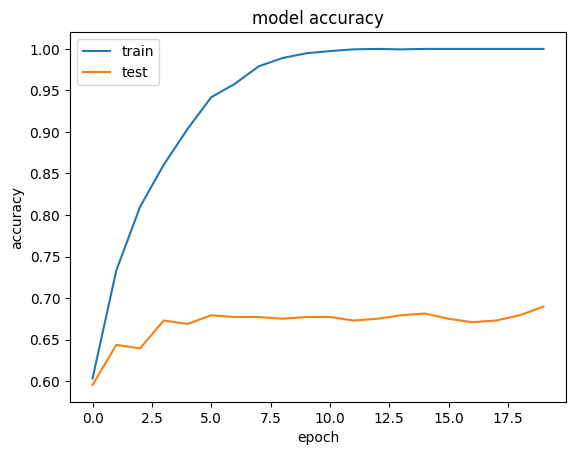

In [192]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### We are now ready to start training the model using


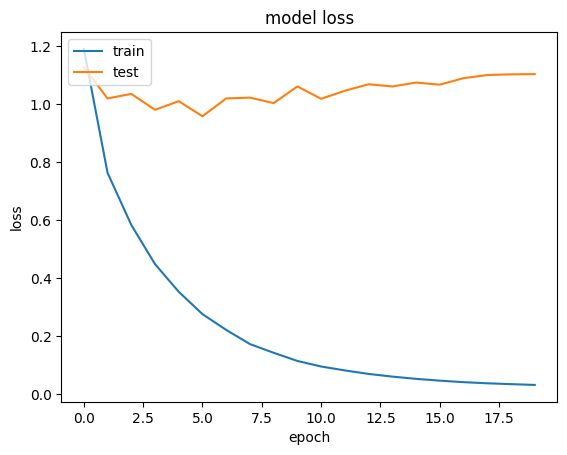

In [193]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()